<a href="https://colab.research.google.com/github/oymin2001/DataScience/blob/main/Vanilla_RNN_%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN

[Written by Andrej Karpathy (@karpathy)](https://gist.github.com/karpathy/d4dee566867f8291f086)

In [ ]:
import numpy as np

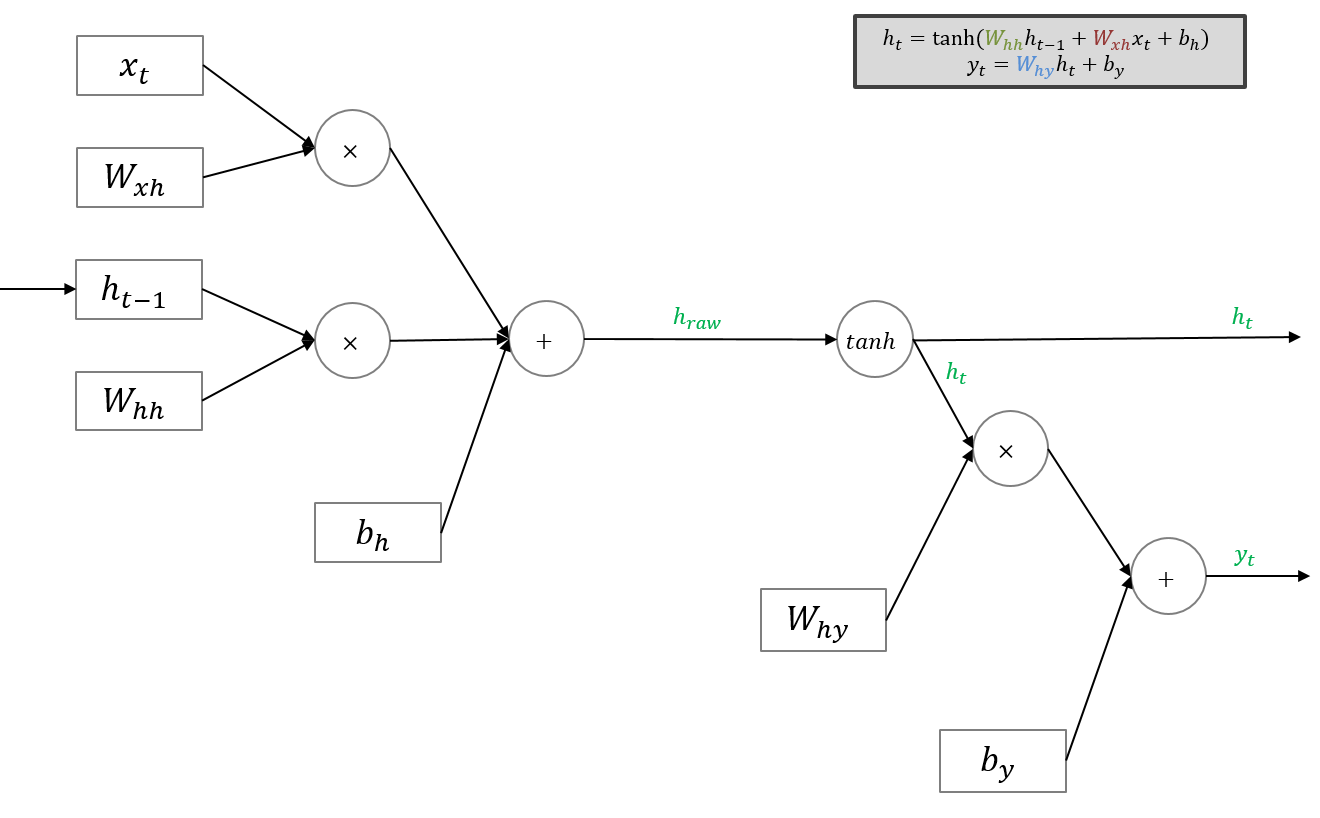

gradient vanishing problem

In [ ]:
data = "abcdefghijklmnopqrstuvwxyz abcdefghijklmnopqrstuvwxyz abcdefghijklmnopqrstuvwxyz "
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [ ]:
char_to_ix = dict((c,i) for i,c in enumerate(chars))
char_to_ix

{'z': 0,
 'j': 1,
 'r': 2,
 'h': 3,
 'p': 4,
 'k': 5,
 'a': 6,
 'c': 7,
 'm': 8,
 'n': 9,
 'f': 10,
 'v': 11,
 'l': 12,
 'g': 13,
 ' ': 14,
 'w': 15,
 'o': 16,
 'u': 17,
 'e': 18,
 't': 19,
 'x': 20,
 'y': 21,
 'd': 22,
 'q': 23,
 'b': 24,
 's': 25,
 'i': 26}

In [ ]:
iter = 500
seq_len = 10
batch_size = round((data_size / seq_len)+0.5)
hidden_size =  100
lr = 1e-1

In [ ]:
weight_scale = 1e-2
params = {
          "Wxh": np.random.randn(hidden_size, vocab_size) * weight_scale,
          "Whh": np.random.randn(hidden_size, hidden_size) * weight_scale,
          "Why": np.random.randn(vocab_size, hidden_size) * weight_scale,
          "bh": np.zeros((hidden_size, 1)),
          "by": np.zeros((vocab_size,1))
        }
Wxh, Whh, Why, bh, by = params.values()
h_prev = np.zeros((hidden_size,1))

In [ ]:
def stable_softmax(x):
    e = np.exp(x-np.max(x))
    return e / e.sum()

In [ ]:
def forward_pass(inputs, targets, h_prev):
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(h_prev) # hs[0] = f(x[0],h[-1])
    loss = 0

    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1))
        xs[t][inputs[t]] = 1 # one-hot-encoded
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
        ys[t] = np.dot(Why, hs[t]) + by
        ps[t] = stable_softmax(ys[t])

        loss += -np.log(ps[t][targets[t],0]) # cross-entropy loss

    cache = (xs, hs, ps, targets)
    return loss, cache

In [ ]:
def backward_pass(inputs, cache):
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    xs, hs, ps, targets = cache
    dhnext = np.zeros_like(hs[0])

    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1

        dby += dy

        dWhy += np.dot(dy, hs[t].T)

        dh = np.dot(Why.T, dy) + dhnext # backprop into h.
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)

        dbh += dhraw

        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)

        dhnext = np.dot(Whh.T, dhraw)

    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: # clip to mitigate exploding gradients
        np.clip(dparam, -5, 5, out=dparam)

    return dWxh, dWhh, dWhy, dbh, dby

In [ ]:
#solver: SGD + Adagrad
data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by)
smooth_loss = -np.log(1.0 / vocab_size) * seq_len

for i in range(iter):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data

    for b in range(batch_size):

        inputs = [char_to_ix[ch] for ch in data[data_pointer:data_pointer+seq_len]]
        targets = [char_to_ix[ch] for ch in data[data_pointer+1:data_pointer+seq_len+1]] # t+1

        if (data_pointer+seq_len+1 >= len(data) and b == batch_size-1): # processing of the last part of the input data.
            targets.append(char_to_ix[" "])   # When the data doesn't fit, add space(" ") to the back.

        loss, cache = forward_pass(inputs, targets, h_prev)
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        dWxh, dWhh, dWhy, dbh, dby = backward_pass(inputs, cache)


        # perform parameter update with Adagrad
        for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                      [dWxh, dWhh, dWhy, dbh, dby],
                                      [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -lr * dparam / np.sqrt(mem + 1e-8) # adagrad update

        data_pointer += seq_len # move data pointer

    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, smooth_loss)) # print progress

iter 0, loss: 32.981427
iter 100, loss: 13.666238
iter 200, loss: 5.562414
iter 300, loss: 2.265941
iter 400, loss: 0.924873


In [ ]:
test_data = 'b'
test_output_len = 40

x = np.zeros((vocab_size, 1))
x[char_to_ix[test_data]] = 1
ixes = []
h = np.zeros((hidden_size, 1))

for t in range(test_output_len):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h)+ bh)
    y = np.dot(Why, h) + by
    p = stable_softmax(y)
    ix = np.random.choice(range(vocab_size), p = p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)

ix_to_char = dict((i,c) for i,c in enumerate(chars))
output = ''.join(ix_to_char[i] for i in ixes)
output # 어느정도 알파벳 순서대로 나옴

'efghijklmnklmghijlqrstuvyzwabcdaefxhijkn'

In [ ]:
class RNN(object):
    def __init__(self, data_size, vocab_size, lr=1e-1, hidden_size=100,seq_length=25, weight_scale = 0.01, iter=1000):
        self.lr = lr
        self.hidden_size = hidden_size
        self.iter = iter
        self.seq_length  = seq_length
        self.data_size = data_size
        self.vocab_size = vocab_size
        self.batch_size = round((data_size /seq_length)+0.5)
        self.params = {
                        "Wxh": np.random.randn(hidden_size, vocab_size) * weight_scale,
                        "Whh": np.random.randn(hidden_size, hidden_size) * weight_scale,
                        "Why": np.random.randn(vocab_size, hidden_size) * weight_scale,
                        "bh": np.zeros((hidden_size, 1)),
                        "by": np.zeros((vocab_size,1))
                      }

    def stable_softmax(self,x):
        e = np.exp(x-x.max())
        return e/e.sum()

    def forward_pass(self,inputs, targets, h_prev,Wxh, Whh, Why, bh, by):
        xs, hs, ys, ps = {}, {}, {}, {}
        hs[-1] = np.copy(h_prev)
        loss = 0

        for t in range(len(inputs)):
            xs[t] = np.zeros((vocab_size,1))
            xs[t][inputs[t]] = 1 # one-hot-encoded
            hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
            ys[t] = np.dot(Why, hs[t]) + by
            ps[t] = self.stable_softmax(ys[t])
            loss += -np.log(ps[t][targets[t],0]) # cross-entropy loss

        cache = (xs, hs, ps, targets,Wxh, Whh, Why, bh, by)
        return loss, cache

    def backward_pass(self,inputs, cache):
        xs, hs, ps, targets,Wxh, Whh, Why, bh, by = cache
        dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
        dbh, dby = np.zeros_like(bh), np.zeros_like(by)
        dhnext = np.zeros_like(hs[0])

        for t in reversed(range(len(inputs))):
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1

            dby += dy

            dWhy += np.dot(dy, hs[t].T)

            dh = np.dot(Why.T, dy) + dhnext # backprop into h.
            dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)

            dbh += dhraw

            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t-1].T)

            dhnext = np.dot(Whh.T, dhraw)

        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)

        return dWxh, dWhh, dWhy, dbh, dby

    def fit(self,data):
        #solver: SGD+Adagrad
        chars = list(set(data))
        self.chars = chars
        self.char_to_ix = {ch:i for i,ch in enumerate(chars)}

        n, p = 0, 0
        Wxh, Whh, Why, bh, by = self.params.values()
        mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
        mbh, mby = np.zeros_like(bh), np.zeros_like(by)
        smooth_loss = -np.log(1.0 / self.vocab_size) * self.seq_length

        for i in range(self.iter):
            h_prev = np.zeros((self.hidden_size,1))
            data_pointer = 0

            for b in range(self.batch_size):
                inputs = [self.char_to_ix[ch] for ch in data[data_pointer:data_pointer+self.seq_length]]
                targets = [self.char_to_ix[ch] for ch in data[data_pointer+1:data_pointer+self.seq_length+1]]

                if (data_pointer+self.seq_length+1 >= len(data) and b == self.batch_size-1):
                    targets.append(self.char_to_ix[" "])


                loss, cache = self.forward_pass(inputs, targets, h_prev,Wxh, Whh, Why, bh, by)
                smooth_loss = smooth_loss * 0.999 + loss * 0.001
                dWxh, dWhh, dWhy, dbh, dby = self.backward_pass(inputs, cache)


                # perform parameter update with Adagrad
                for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                      [dWxh, dWhh, dWhy, dbh, dby],
                                      [mWxh, mWhh, mWhy, mbh, mby]):
                    mem += dparam * dparam # elementwise
                    param += -self.lr * dparam / np.sqrt(mem + 1e-8) # adagrad update

                data_pointer += self.seq_length # move data pointer

            if i % 500 == 0:
                print ('iter %d, loss: %f' % (i, smooth_loss)) # print progress

        self.params['Wxh'],self.params['Whh'],self.params['Why'],self.params['bh'],self.params['by'] =  Wxh, Whh, Why, bh, by

    def predict(self, input, output_len=50):
        x = np.zeros((self.vocab_size, 1))
        x[self.char_to_ix[input]] = 1
        ixes = []
        h = np.zeros((self.hidden_size, 1))
        Wxh, Whh, Why, bh, by = self.params.values()

        for t in range(output_len):
            h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h)+ bh)
            y = np.dot(Why, h) + by
            p = self.stable_softmax(y)
            ix = np.random.choice(range(self.vocab_size), p = p.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[ix] = 1
            ixes.append(ix)

        self.ix_to_char = dict((i,c) for i,c in enumerate(self.chars))
        output = ''.join(self.ix_to_char[i] for i in ixes)
        return output

In [ ]:
data = "대립하는 가운데서만 그것은 자신을 필연적인 것으로 느끼게 되며 또한 대립하는 가운데서만 비로소 필연적인 것이 된다. 우리는 대립하는 것을 풍부하게 갖는 것을 대가로 해서만 우리는 풍요로운 결실을 맺을 수 있으며 영혼이 긴장을 풀지 않고 평화를 구하지 않는다는 전제 아래에서만 젊음을 유지할 수 있다."
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)

In [ ]:
rnn = RNN(data_size=data_size, vocab_size=vocab_size,iter=5000)
rnn.fit(data)

iter 0, loss: 105.836462
iter 500, loss: 4.053224
iter 1000, loss: 0.191821
iter 1500, loss: 0.046425
iter 2000, loss: 0.029875
iter 2500, loss: 0.022708
iter 3000, loss: 0.018327
iter 3500, loss: 0.015349
iter 4000, loss: 0.013192
iter 4500, loss: 0.011560


In [ ]:
rnn.predict('대')

'립하는 가운데서만 그것은 자신을 필연적인 것으며 또한 대립하는 가운데서만 그것은 자신을 필'

In [ ]:
rnn.predict("풍")

'요로운 결실을 맺을 수 있으며 영혼이 긴장을 되며필연적인 것이 된다. 우리는 대립하는 것을'

# LSTM

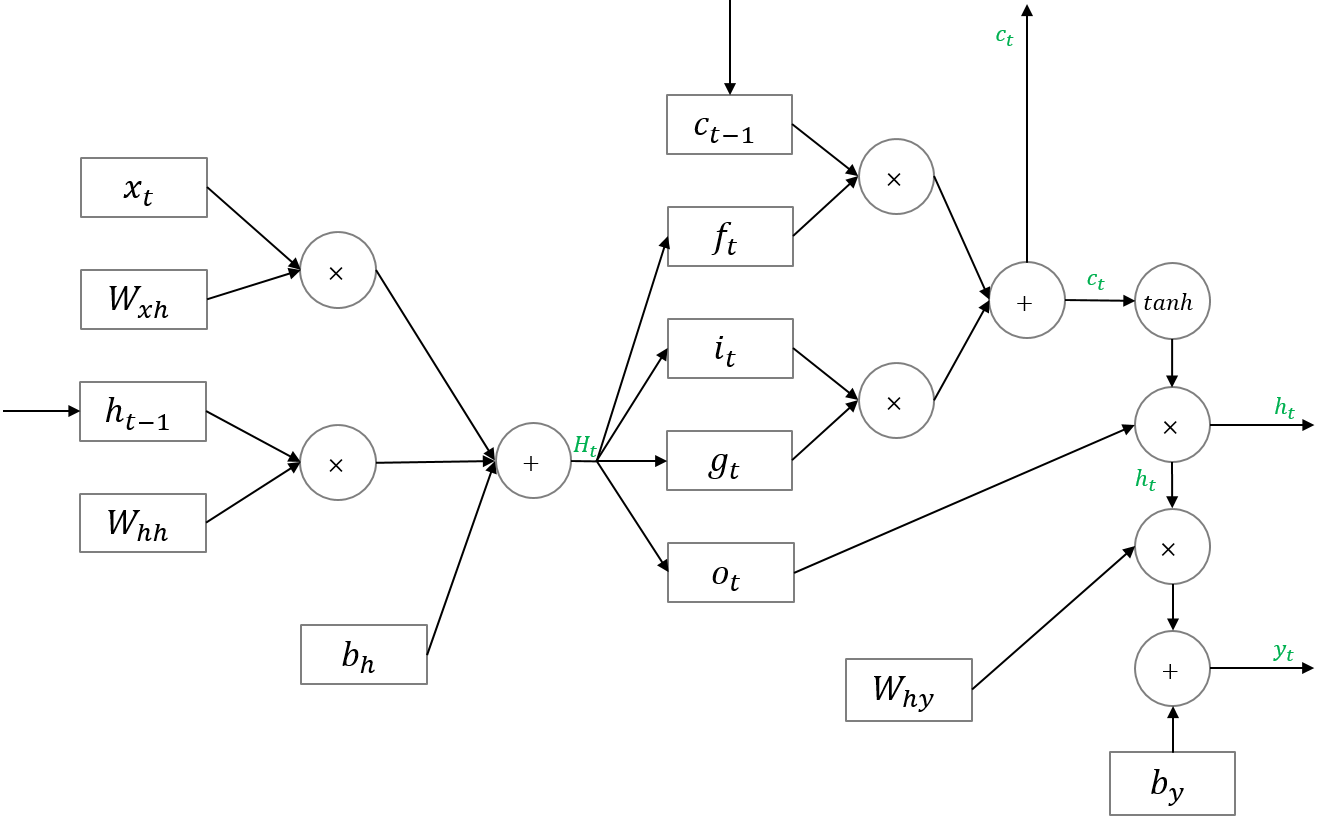

\begin{align*}
{ f }_{ t }&=\sigma ({ W }_{ xh\_ f }{ x }_{ t }+{ W }_{ hh\_ f }{ h }_{ t-1 }+{ b }_{ h\_ f })\\ { i }_{ t }&=\sigma ({ W }_{ xh\_ i }{ x }_{ t }+{ W }_{ hh\_ i }{ h }_{ t-1 }+{ b }_{ h\_ i })\\ { o }_{ t }&=\sigma ({ W }_{ xh\_ o }{ x }_{ t }+{ W }_{ hh\_ o }{ h }_{ t-1 }+{ b }_{ h\_ o })\\ { g }_{ t }&=\tanh { ({ W }_{ xh\_ g }{ x }_{ t }+{ W }_{ hh\_ g }{ h }_{ t-1 }+{ b }_{ h\_ g }) } \\ { c }_{ t }&={ f }_{ t }\odot { c }_{ t-1 }+{ i }_{ t }\odot { g }_{ t }\\ { h }_{ t }&={ o }_{ t }\odot \tanh { ({ c }_{ t }) }
\end{align*}

In [ ]:
class LSTM(object):
    def __init__(self, data_size, vocab_size, lr=1e-1, hidden_size=100,seq_length=25, weight_scale = 0.01, iter=1000):
        self.lr = lr
        self.hidden_size = hidden_size
        self.iter = iter
        self.seq_length  = seq_length
        self.data_size = data_size
        self.vocab_size = vocab_size
        self.batch_size = round((data_size /seq_length)+0.5)
        self.params = {
                        "Wxh": np.random.randn(4,hidden_size, vocab_size) * weight_scale,
                        "Whh": np.random.randn(4,hidden_size, hidden_size) * weight_scale,
                        "Why": np.random.randn(vocab_size, hidden_size) * weight_scale,
                        "bh": np.zeros((4,hidden_size, 1)),
                        "by": np.zeros((vocab_size,1))
                      }

    def stable_softmax(self,x):
        e = np.exp(x-x.max())
        return e/e.sum()

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def forward_pass(self,inputs, targets, h_prev,c_prev,Wxh, Whh, Why, bh, by):
        xs, hs, ys, ps, fs, iis, os, gs, cs, hs = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
        hs[-1] = np.copy(h_prev)
        cs[-1] = np.copy(c_prev)
        loss = 0

        for t in range(len(inputs)):
            xs[t] = np.zeros((vocab_size,1))
            xs[t][inputs[t]] = 1 # one-hot-encoded (V,1)

            fs[t] = self.sigmoid(np.dot(Wxh[0,:,:], xs[t]) + np.dot(Whh[0,:,:], hs[t-1]) + bh[0,:,:]) # forget gate, (H,1)
            iis[t] = self.sigmoid(np.dot(Wxh[1,:,:], xs[t]) + np.dot(Whh[1,:,:], hs[t-1]) + bh[1,:,:]) # input gate
            os[t] = self.sigmoid(np.dot(Wxh[2,:,:], xs[t]) + np.dot(Whh[2,:,:], hs[t-1]) + bh[2,:,:]) # output gate
            gs[t] = np.tanh(np.dot(Wxh[3,:,:], xs[t]) + np.dot(Whh[3,:,:], hs[t-1]) + bh[3,:,:]) # gate gate?

            cs[t] = fs[t] * cs[t-1] + iis[t] * gs[t]
            hs[t] = os[t] * np.tanh(cs[t])
            ys[t] = np.dot(Why, hs[t]) + by
            ps[t] = self.stable_softmax(ys[t])
            loss += -np.log(ps[t][targets[t],0])


        cache = (xs, hs, ps, targets, fs, iis, os, gs, cs,Wxh, Whh, Why, bh, by)
        return loss, cache

    def backward_pass(self,inputs, cache):
        xs, hs, ps, targets, fs, iis, os, gs, cs,Wxh, Whh, Why, bh, by = cache

        dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
        dbh, dby = np.zeros_like(bh), np.zeros_like(by)
        dhnext, dcnext = np.zeros_like(hs[0]), np.zeros_like(cs[0])

        for t in reversed(range(len(inputs))):
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1
            dby += dy
            dWhy += np.dot(dy, hs[t].T)

            dh = np.dot(Why.T, dy) + dhnext

            dc = (1 - np.tanh(cs[t]) * np.tanh(cs[t])) * dh * os[t] + dcnext
            dcnext = dc * fs[t]
            df = dc * cs[t-1]
            di = dc * gs[t]
            do = dh * np.tanh(cs[t])
            dg = dc * iis[t]

            ddf = (1-fs[t]) * fs[t] * df
            ddi = (1-iis[t]) * iis[t] * di
            ddo = (1-os[t]) * os[t] * do
            ddg = (1-gs[t]**2) * dg

            dWxh[0,:,:] += np.dot(ddf, xs[t].T)
            dWhh[0,:,:] += np.dot(ddf, hs[t-1].T)
            dbh[0,:,:] += ddf

            dWxh[1,:,:] += np.dot(ddi, xs[t].T)
            dWhh[1,:,:] += np.dot(ddi, hs[t-1].T)
            dbh[1,:,:] += ddi

            dWxh[2,:,:] += np.dot(ddo, xs[t].T)
            dWhh[2,:,:] += np.dot(ddo, hs[t-1].T)
            dbh[2,:,:] += ddo

            dWxh[3,:,:] += np.dot(ddg, xs[t].T)
            dWhh[3,:,:] += np.dot(ddg, hs[t-1].T)
            dbh[3,:,:] += ddg

            dz = (np.dot(Whh[0,:,:].T, ddf) + np.dot(Whh[1,:,:].T, ddi) + np.dot(Whh[2,:,:].T, ddg) + np.dot(Whh[3,:,:].T, ddo))
            dhnext = dz[:self.hidden_size, :] ##################


        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)

        return dWxh, dWhh, dWhy, dbh, dby

    def fit(self,data):
        #solver: SGD+Adagrad
        chars = list(set(data))
        self.chars = chars
        self.char_to_ix = {ch:i for i,ch in enumerate(chars)}

        n, p = 0, 0
        Wxh, Whh, Why, bh, by = self.params.values()
        mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
        mbh, mby = np.zeros_like(bh), np.zeros_like(by)
        smooth_loss = -np.log(1.0 / self.vocab_size) * self.seq_length

        for i in range(self.iter):
            h_prev, c_prev = np.zeros((self.hidden_size,1)), np.zeros((self.hidden_size,1))
            data_pointer = 0

            for b in range(self.batch_size):
                inputs = [self.char_to_ix[ch] for ch in data[data_pointer:data_pointer+self.seq_length]]
                targets = [self.char_to_ix[ch] for ch in data[data_pointer+1:data_pointer+self.seq_length+1]]

                if (data_pointer+self.seq_length+1 >= len(data) and b == self.batch_size-1):
                    targets.append(self.char_to_ix[" "])


                loss, cache = self.forward_pass(inputs, targets, h_prev, c_prev, Wxh, Whh, Why, bh, by)
                smooth_loss = smooth_loss * 0.999 + loss * 0.001
                dWxh, dWhh, dWhy, dbh, dby = self.backward_pass(inputs, cache)


                # perform parameter update with Adagrad
                for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                      [dWxh, dWhh, dWhy, dbh, dby],
                                      [mWxh, mWhh, mWhy, mbh, mby]):
                    mem += dparam * dparam # elementwise
                    param += -self.lr * dparam / np.sqrt(mem + 1e-8) # adagrad update

                data_pointer += self.seq_length # move data pointer

            if i % 500 == 0:
                print ('iter %d, loss: %f' % (i, smooth_loss)) # print progress

        self.params['Wxh'],self.params['Whh'],self.params['Why'],self.params['bh'],self.params['by'] =  Wxh, Whh, Why, bh, by

    def predict(self, input, output_len=50):
        x = np.zeros((self.vocab_size, 1))
        x[self.char_to_ix[input]] = 1
        ixes = []
        h,c = np.zeros((self.hidden_size, 1)),  np.zeros((self.hidden_size, 1))
        Wxh, Whh, Why, bh, by = self.params.values()

        for t in range(output_len):
            f = self.sigmoid(np.dot(Wxh[0,:,:],x) + np.dot(Whh[0,:,:], h) + bh[0,:,:])
            i = self.sigmoid(np.dot(Wxh[0,:,:],x) + np.dot(Whh[0,:,:], h) + bh[0,:,:])
            o = self.sigmoid(np.dot(Wxh[0,:,:],x) + np.dot(Whh[0,:,:], h) + bh[0,:,:])
            g = np.tanh(np.dot(Wxh[0,:,:],x) + np.dot(Whh[0,:,:], h) + bh[0,:,:])
            c = f * c + i * g
            h = o * np.tanh(c)
            y = np.dot(Why, h) + by
            p = self.stable_softmax(y)

            ix = np.random.choice(range(self.vocab_size), p = p.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[ix] = 1
            ixes.append(ix)

        self.ix_to_char = dict((i,c) for i,c in enumerate(self.chars))
        output = ''.join(self.ix_to_char[i] for i in ixes)
        return output

In [ ]:
data_path = "/content/야스오 대사모음.txt"
data = open(data_path, 'r').read().replace('\n'," ")
data

'모든 검에는 주인이 있는법. 내 검으로 암흑을 부르리라. 자유는 쟁취하는것. 모든 규칙은 깨라고 있는법. 밤이 새벽을 찢는다. 너의 규칙부터 깨주지. 의지가 흔들리고 있군. 고통..혼돈..! 삶의 이유! 세상을 갈기 갈기 찢어주마. 혼돈을 널 다시 태어나게 해줄 터. 빛은 날 두려워하기 마련. 이기적인 욕망에 흠뻑 취한 꼴이라니. 넌 부러질 운명이다. 암흑으로 오라. 평화는 허상이다. 난 빛을 사냥하지. 혼돈이 널 부러뜨릴 것이다. 질서는 거짓일 뿐. 혼돈이 답이다. 어느 편에 설 지 정해라. 혁명은 불가피한 것. 의지는 나약함의 표상이다. 이 검은 내 영혼. 혼돈은 우리 모두에게서 타오른다. 통제는 영혼을 숨막히게 하는것 분노를 끌어모아라! 모든 질서엔 은밀한 무질서가 있지. 니 안에 불신이 들끓고 있군. 내가 바로 너의 악마다. 후회는 없다. 분노의 고삐를 풀어라 불협화음이 내 영혼에 불을 지피는군. 분노를 꺼내라. 대화로 풀어보겠다고?..웃기지 마라. 고독한 싸움이 가장 강한 법. 우린 부딪쳐 싸울 수 밖에 없는 운명이다. 널 끝도 없는 구렁텅이에 빠뜨려주마. 암흑은 구속 될 수 없다. 질서엔 관심 없다. 니 안에 암흑을 부정하다니. 내가 두렵다고? 잘 됐군. 빛을 따르는 것은 이기적인 기도일 뿐. 혼돈을 탈출할 길은 없다. 싸워라! 혼돈이 널 집어삼키도록. 혼돈 속에서 거짓이 드러나는 법. 완벽 타령은 저리 치워라.! 너에게 필요한 건 암흑이다. 천사여, 언제 포기할텐가. 빛을 진실로 착각하고 있다니. 혼돈이 속박이라고? 진정한 자유다. 니 자신의 빛에 눈이 멀었군. 니 악마가 암흑 속에 꿈틀대고 있다. 죽음 앞에서 진실이 무슨 소용이란 말인가. 완벽은 가장 잔인한 거짓말에 불과해. 날개라니. 그건 족쇄일 뿐이야. 혼돈 앞에서 너의 날개는 꺾일 것이다. 받아들이시지. 내 자유가 널 두렵게 한다는걸 널 암흑으로 인도할 자는 나다. 이렇게 나는 암흑이 되었다. 길은 선택 할 수도. 운명일 수도 있지. 오직 암흑과 빛이 있을 뿐. 중간은 없다. 어제는 꿈이

In [ ]:
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)

In [ ]:
lstm = LSTM(data_size=data_size, vocab_size=vocab_size, iter=5000)
lstm.fit(data)

iter 0, loss: 143.239639
iter 500, loss: 37.523994
iter 1000, loss: 37.147324
iter 1500, loss: 37.870420
iter 2000, loss: 35.986937
iter 2500, loss: 37.627870
iter 3000, loss: 35.294510
iter 3500, loss: 37.663171
iter 4000, loss: 34.371389
iter 4500, loss: 36.428088


In [ ]:
lstm.predict('우')

' 날.다이법.아이이앞은선편최때라편의할밀 이으이잿.법.  의 만길이이끌  .법이것.법 끌만끝'

In [ ]:
lstm.predict('암')

' .널이아선이자는.균 길.선이 잘은잘텅이을.소온증  진할우끌을더법 꼴꼴꼴 끌 아진법진진진여'

In [ ]:
lstm.predict('내')

'  날 만법 널  잘이.  선지   에    할의 할  의만 라 할 다만만   진진랍로진아'

In [ ]:
import pickle

params = lstm.params
with open('lstm_params.pkl','wb') as f:
    pickle.dump(params, f)